In [1]:
library(liana)
library(dplyr)
library(Seurat)
library(ggpubr)
library(pheatmap)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: ggplot2



In [2]:
mergeData = function(mat, 
                     meta, 
                     clusterCol_name, 
                     type = 'mean'){
  meta = meta[colnames(mat),]
  res = vector(mode = 'list',length = length(unique(meta[,`clusterCol_name`])))
  names(res) = unique(meta[,`clusterCol_name`])
  for(x in unique(meta[,`clusterCol_name`])){
    sub_mat = as.matrix(mat[,which(meta[,`clusterCol_name`] == x)])
    if(type == 'mean'){
      res[[x]] = rowMeans(sub_mat)
    }else if(type == 'mean_expressed'){
      sub_mat[which(sub_mat == 0)] = NA
      res[[x]] = rowMeans(sub_mat, na.rm = TRUE)
    }else if(type == 'median'){
      res[[x]] = apply(sub_mat, 1, median)
    }
  }
  res = do.call('cbind',res)
  res[is.na(res)] = 0
  res
}

In [70]:
meta = read.csv('./results/Step1_allCluster/meta_info.csv',row.names=1,check.names = 0)

In [71]:
aa = table(meta$Patients, meta$cellTypes_subsets)
aa = aa/rowSums(aa)

In [73]:
cor = c()
celltype = c()
pvals = c()
for(c in unique(meta$cellTypes_subsets)){
    celltype = c(celltype, c)
    cor = c(cor, as.numeric(cor.test(aa[,'CD8_GZMK'], aa[,c])$estimate))
    pvals = c(pvals, as.numeric(cor.test(aa[,'CD8_GZMK'], aa[,c])$p.value))
}
dd = data.frame(celltype = celltype, cor = cor, pval = pvals)
dd = dd[order(dd$cor,decreasing = T),]
dd = dd[dd$pval<0.3,]
dd = dd[dd$cor !=1, ]
dd$log10P = -log10(dd$pval)
dd$color = as.character(dd$pval<0.05)
dd

,celltype,cor,pval,log10P,color
,<chr>,<dbl>,<dbl>,<dbl>,<chr>
36,NK,0.8214196,8.359246e-11,10.0778329,TRUE
20,LEC,0.7077401,3.271160e-07,6.4852982,TRUE
34,CD4_Treg,0.6028480,3.843778e-05,4.4152417,TRUE
37,CD8_LAG3,0.5424346,2.994291e-04,3.5237060,TRUE
22,pDC,0.5086156,8.049303e-04,3.0942417,TRUE
31,CD8_CD4_low,0.5020247,9.646952e-04,3.0156099,TRUE
39,CD4_FOS,0.4314804,5.437577e-03,2.2645946,TRUE
29,CAF_ATCA2,0.4309010,5.507389e-03,2.2590543,TRUE
32,CD4_Tfh,0.4227326,6.577354e-03,2.1819488,TRUE


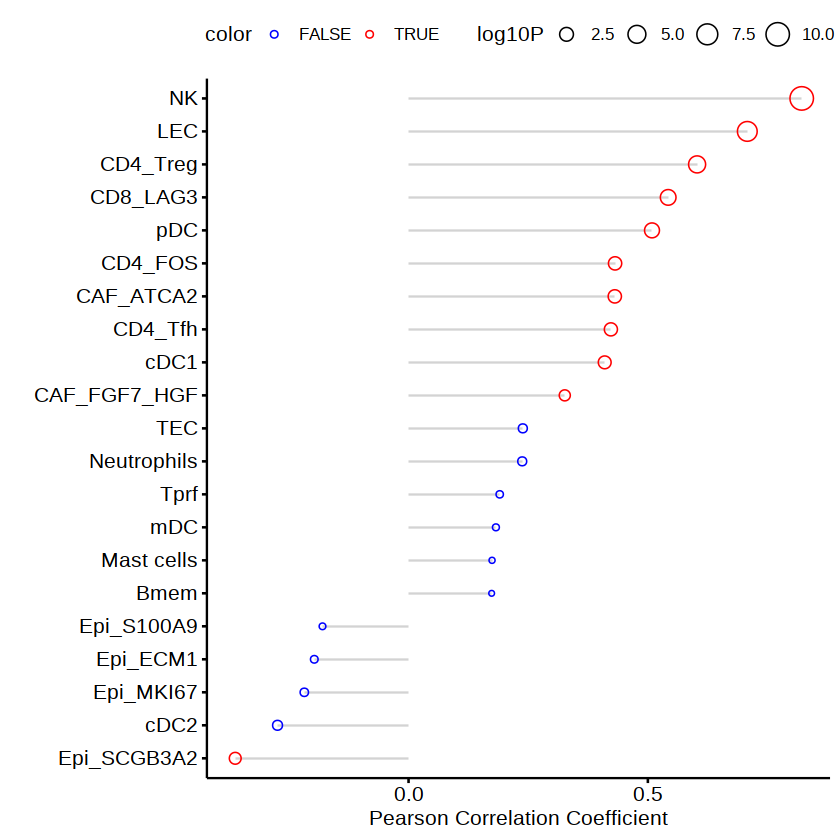

In [78]:
ggdotchart(dd[which(dd$celltype != 'CD8_CD4_low'),], x = "celltype", y = "cor",
           color = "color",       
           palette = c("blue", "red"),
           add = "segments",    
           sorting = "descending",
           xlab="",
           shape=1,
           dot.size = "log10P",
           rotate = TRUE,
           ylab = 'Pearson Correlation Coefficient'
)

In [18]:
tcell$mutation_cellType = paste(tcell$mutation, tcell$cellType)

In [24]:
tcell = tcell[,which(tcell$cluster_name_0515 != 'Prolif')]
tcell = tcell[,which(tcell$cluster_name_0515 != 'CD8_CD4_low')]
tcell = tcell[,which(tcell$cluster_name_0515 != 'NK')]

In [77]:
merged = mergeData(tcell@assays$RNA@data[,which(tcell$cellType %in% c('CD8_Naive-like','CD8_LAG3','CD8_GZMK'))],
                      tcell@meta.data,
                      'mutation_cellType',
                      'mean'
                     )

In [78]:
center = sweep(merged,1,apply(merged, 1, min),'-')
R = apply(merged, 1, max) - apply(merged, 1, min)
scaled = sweep(center,1,R,'/')

In [48]:
center = sweep(merged,1,apply(merged, 1, mean),'-')
R = apply(merged, 1, sd)
scaled = sweep(center,1,R,'/')

In [28]:
scaled[c('TCF7','HIF1A','LEF1','SLAMF6','MAF','ID2','RUNX1'),
       c('L858R CD8_GZMK','Del19 CD8_GZMK','L858R CD8_LAG3','Del19 CD8_LAG3')]

,L858R CD8_GZMK,Del19 CD8_GZMK,L858R CD8_LAG3,Del19 CD8_LAG3
TCF7,0.4903046,0.24984219,0.2856672,0.277428759
HIF1A,0.5147665,0.35970307,0.6703277,0.352637211
LEF1,0.1167952,0.03397865,0.1624570,0.081684641
SLAMF6,0.9510082,0.68613753,0.4192400,0.334308801
MAF,0.2909136,0.13820432,0.0659657,0.003575531
ID2,0.4610594,0.58033811,0.8858303,1.000000000
RUNX1,0.5229431,0.50058077,0.1893038,0.296099926


In [55]:
library(RColorBrewer)

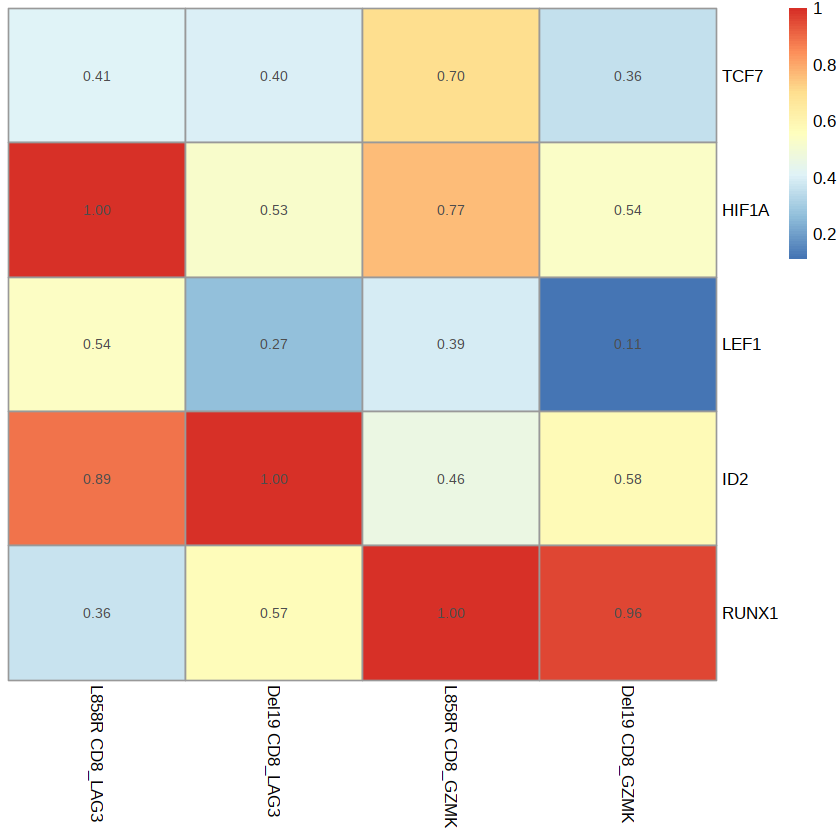

In [83]:
p = pheatmap(scaled[c('TCF7','HIF1A','LEF1','ID2','RUNX1'),
                c('L858R CD8_LAG3','Del19 CD8_LAG3','L858R CD8_GZMK','Del19 CD8_GZMK')],
         #color = colorRampPalette(c("navy", "white", "firebrick3"))(50),
                       #scale ='row',
         display_numbers = TRUE,
                  cluster_rows = F,
                   cluster_cols = F)

In [16]:
colnames(merged)

[1] "CD4_Tfh"        "CD8_GZMK"       "NK"             "CD4_Treg"      
[5] "CD8_LAG3"       "CD4_Naive-like" "CD4_FOS"        "CD8_Naive-like"
[9] "CD4_ANXA1"

In [17]:
cd4 = c('CD4_Naive-like','CD4_FOS','CD4_ANXA1','CD4_Treg','CD4_Tfh')
cd8 = c('CD8_Naive-like','CD8_GZMK','CD8_LAG3')


In [19]:
library(RColorBrewer)

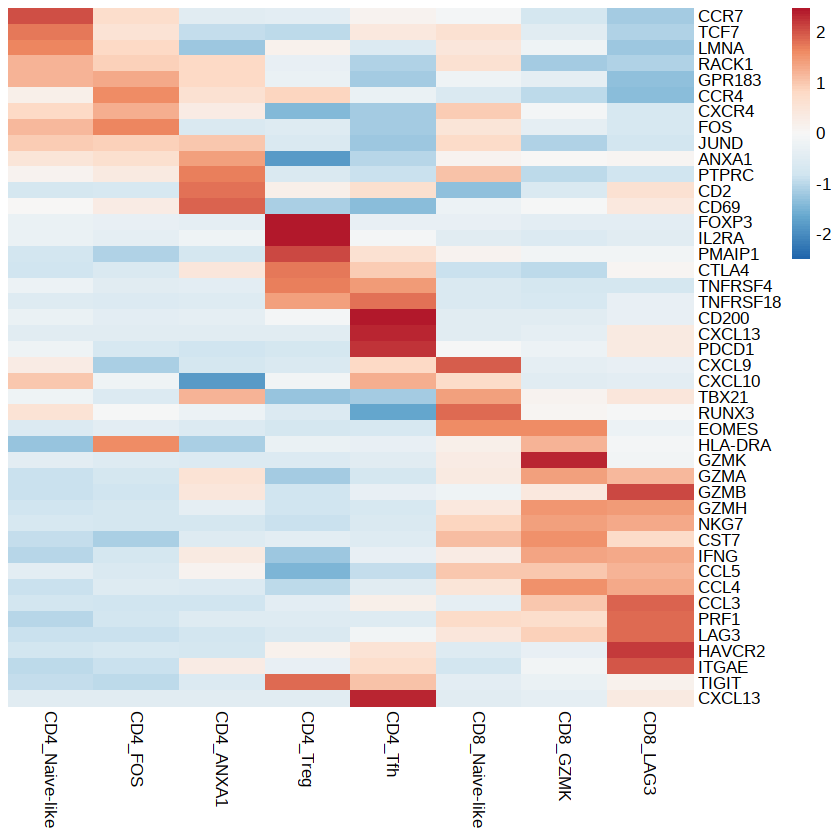

In [28]:
test_genes = c('CCR7','TCF7','LMNA','RACK1','GPR183',
               'CCR4','CXCR4','FOS', 
               'JUND', 'ANXA1','PTPRC','CD2','CD69',
               'FOXP3', 'IL2RA','PMAIP1','CTLA4','TNFRSF4','TNFRSF18', 
               'CD200', 'CXCL13', 'PDCD1', 
               'CXCL9','CXCL10','TBX21','RUNX3','EOMES',
               'HLA-DRA','GZMK','GZMA','GZMB','GZMH','NKG7','CST7','IFNG','CCL5','CCL4','CCL3','PRF1',
               'LAG3','HAVCR2','ITGAE','TIGIT','CXCL13'
              )
p = pheatmap::pheatmap(merged[test_genes,c(cd4,cd8)],
             cluster_rows = F,cluster_cols = F,scale = 'row', 
             show_rownames=T,
             border_color=NA,
             color = colorRampPalette(rev(brewer.pal(n=7,name='RdBu')))(100))

In [88]:
rm(merged)

In [4]:
data = readRDS('./results/Step1_allCluster/Filtered_merged_20231108.rds')

In [28]:
dim(data@assays$RNA@scale.data)

[1]  4000 80026

In [34]:
merged_caf =  mergeData(data@assays$RNA@data[,which(data$cluster_name_0919 %in% c('Fibroblasts'))],
          data@meta.data,
                         'cellTypes_subsets','mean')
merged_tcell =  mergeData(data@assays$RNA@data[,which(data$cluster_name_0919 %in% c('T cells'))],
          data@meta.data,
                         'cellTypes_subsets','mean')

In [45]:
scale_mat = function(mat,func = 'minMax'){
    if(func == 'minMax'){
        center = sweep(mat,1,apply(mat, 1, min),'-')
        R = apply(mat, 1, max) - apply(mat, 1, min)
        scaled = sweep(center,1,R,'/')
    }else{
        center = sweep(mat,1,apply(mat, 1, mean),'-')
        R = apply(mat, 1, sd)
        scaled = sweep(center,1,R,'/')
    }
    return(scaled)
}

In [46]:
scaled_merged_caf = scale_mat(merged_caf[,c('CAF_FGF7_HGF','CAF_FGF7','CAF_ATCA2')],'sd')

In [17]:
data$cellType_mutation = paste(data$cellTypes_subsets, data$mutation)

In [35]:
merged_tcell_m =  mergeData(data@assays$RNA@data[,which(data$cluster_name_0919 %in% c('T cells'))],
          data@meta.data,
                         'cellType_mutation','mean')

In [40]:
colnames(merged_tcell_m)

[1] "Tprf L858R"           "CD4_Tfh L858R"        "Tprf Del19"          
 [4] "CD8_CD4_low Del19"    "CD8_GZMK L858R"       "CD8_CD4_low L858R"   
 [7] "NK L858R"             "CD4_Treg L858R"       "CD8_GZMK WT"         
[10] "CD8_CD4_low WT"       "CD4_Treg WT"          "Tprf WT"             
[13] "CD4_Tfh WT"           "CD8_LAG3 WT"          "NK WT"               
[16] "CD4_Treg Del19"       "CD4_Tfh Del19"        "CD8_LAG3 L858R"      
[19] "Epi_MKI67 L858R"      "CD8_LAG3 Del19"       "CD8_GZMK Del19"      
[22] "NK Del19"             "CD4_Naive-like Del19" "Bmem Del19"          
[25] "Epi_ECM1 WT"          "Epi_MKI67 WT"         "CD4_FOS Del19"       
[28] "CD8_Naive-like Del19" "CD4_FOS WT"           "CD4_GZMB WT"         
[31] "CD4_Naive-like WT"    "CD4_GZMB Del19"       "CD4_FOS L858R"       
[34] "CD4_GZMB L858R"       "CD4_Naive-like L858R" "mDC L858R"           
[37] "CD8_Naive-like L858R" "CD8_Naive-like WT"    "Bmem WT"             
[40] "Monocyte Del19"

In [48]:
scaled_merged_tcell_m = scale_mat(merged_tcell_m[,c('CD8_GZMK Del19','CD8_GZMK L858R','CD8_GZMK WT')],'sd')

In [47]:
scaled_merged_caf[c('CXCL12','CXCL14','CXCL9','ICAM1','SPON2'),]

,CAF_FGF7_HGF,CAF_FGF7,CAF_ATCA2
CXCL12,0.7714336,0.3583717,-1.129805
CXCL14,0.6931694,0.4531885,-1.146358
CXCL9,0.3691002,0.7629855,-1.132086
ICAM1,0.7835504,0.3427563,-1.126307
SPON2,0.2583233,0.8454930,-1.103816


In [50]:
scaled_merged_tcell_m[c('CXCR3','CXCR4','IL2RG','ITGB2'),c('CD8_GZMK Del19','CD8_GZMK L858R')]

,CD8_GZMK Del19,CD8_GZMK L858R
CXCR3,-0.83437697,-0.2740866
CXCR4,0.06738594,0.9646028
IL2RG,0.37037116,0.7619780
ITGB2,-1.14470518,0.4410608


png 
  2

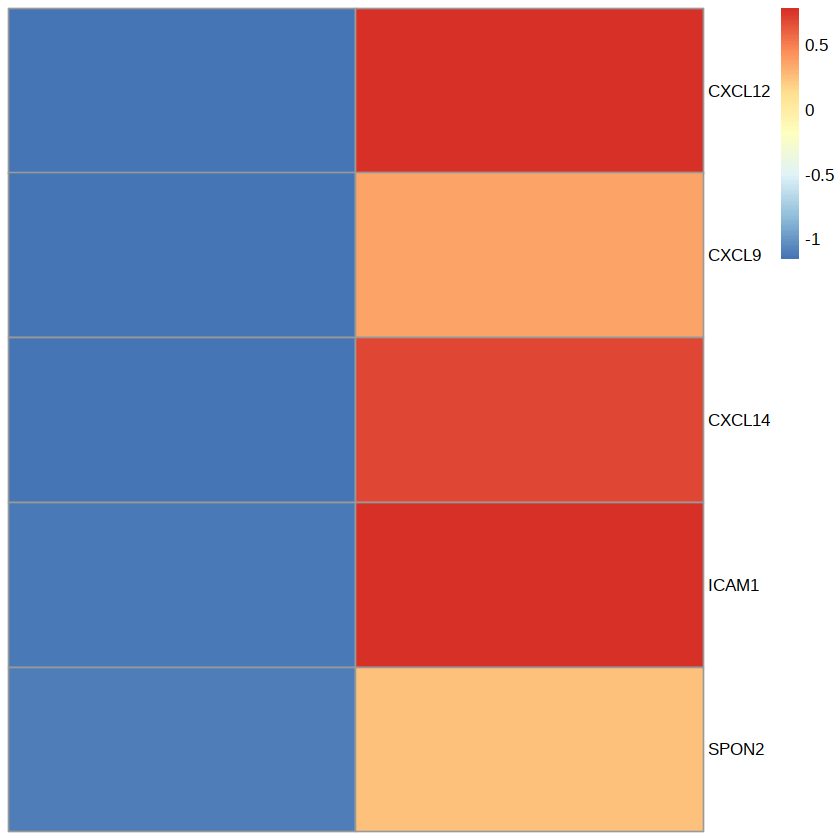

In [55]:
p = pheatmap::pheatmap(scaled_merged_caf[c('CXCL12','CXCL9','CXCL14','ICAM1','SPON2'),rev(c('CAF_FGF7_HGF','CAF_ATCA2'))],
                  #scale ='row',
                  cluster_rows = F,
                   cluster_cols = F,
                   show_colnames  = F
                  )

pdf('./results//figures/published/Figure4/heatmap_interaction_cafs.pdf',width = 2.8,height = 4.6)
print(p)
dev.off()

png 
  2

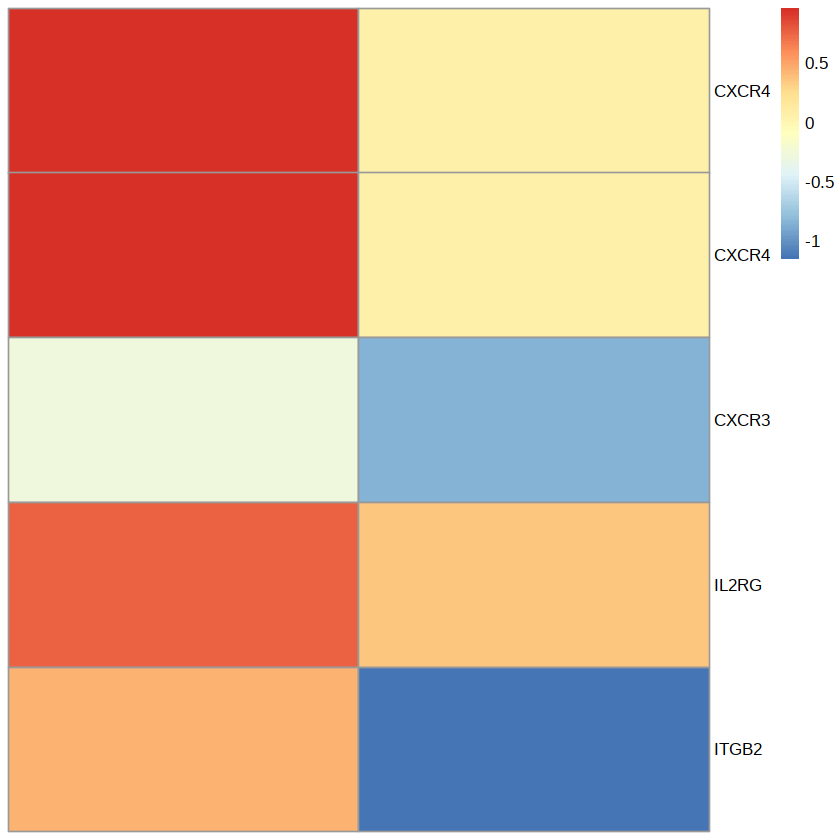

In [54]:
p = pheatmap::pheatmap(scaled_merged_tcell_m[c('CXCR4','CXCR4','CXCR3','IL2RG','ITGB2'),c('CD8_GZMK L858R','CD8_GZMK Del19')],
                  #scale ='row',
                  cluster_rows = F,
                   cluster_cols = F,
                   show_colnames  = F
                  )
pdf('./results//figures/published/Figure4/heatmap_interaction_Tcells.pdf',width = 2.8,height = 4.6)
print(p)
dev.off()

In [ ]:
liana_test = liana_wrap(data[,which(data$cellTypes_subsets %in% c('CAF_FGF7_HGF','CD8_GZMK','CAF_ATCA2'))], 
                        idents_col = 'cellTypes_subsets')

Expression from the `SCT` assay will be used

Running LIANA with `cluster_name_1107` as labels!

`Idents` were converted to factor

Warning message in exec(output, ...):
“289 genes and/or 0 cells were removed as they had no counts!”
Warning message:
“`invoke()` is deprecated as of rlang 0.4.0.
Please use `exec()` or `inject()` instead.
This warning is displayed once every 8 hours.”
LIANA: LR summary stats calculated!

Now Running: Natmi

Now Running: Connectome

Now Running: Logfc

Now Running: Sca

Now Running: Cellphonedb

Warning message:
“`progress_estimated()` was deprecated in dplyr 1.0.0.
ℹ The deprecated feature was likely used in the liana package.
  Please report the issue at <https://github.com/saezlab/liana/issues>.”


In [3]:
liana_test = readRDS('./results/Step3_interaction/liana/cd8_cafs.rds')

In [10]:
liana_test <- liana_test %>%
  liana_aggregate()
#liana_test_plot = liana_test[order(liana_test$mean_rank,decreasing = F),]
#liana_test_plot = liana_test_plot[which(liana_test_plot$cellphonedb.pvalue<0.05),]

Now aggregating natmi

Now aggregating connectome

Now aggregating logfc

Now aggregating sca

Now aggregating cellphonedb

Aggregating Ranks



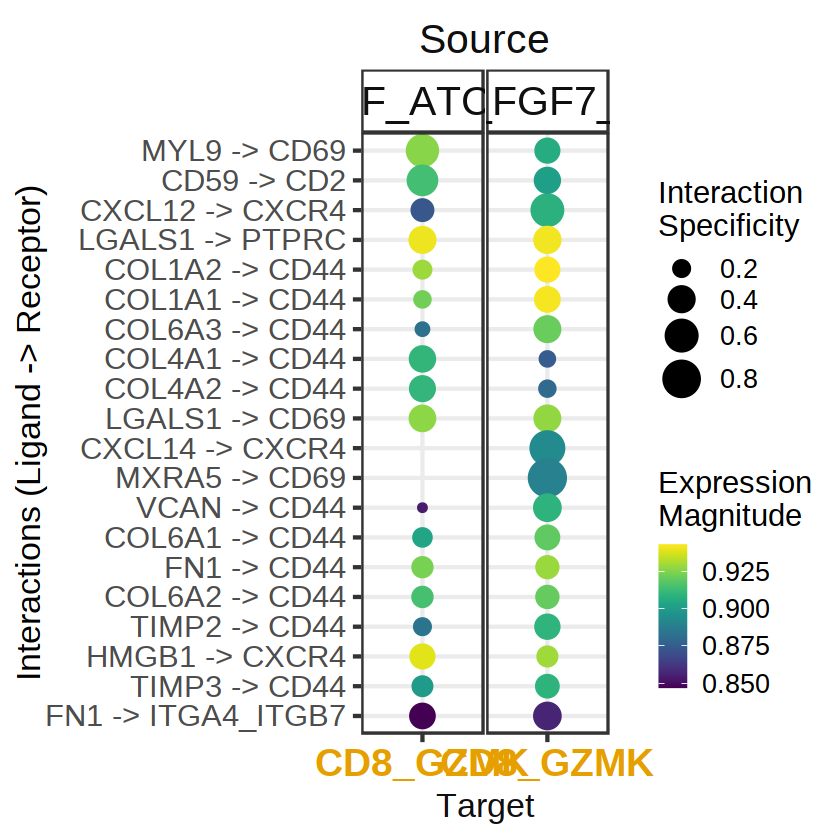

In [13]:
liana_test_plot %>%
  liana_dotplot(source_groups = c('CAF_FGF7_HGF','CAF_ATCA2'),
                target_groups = c("CD8_GZMK"),ntop=20)

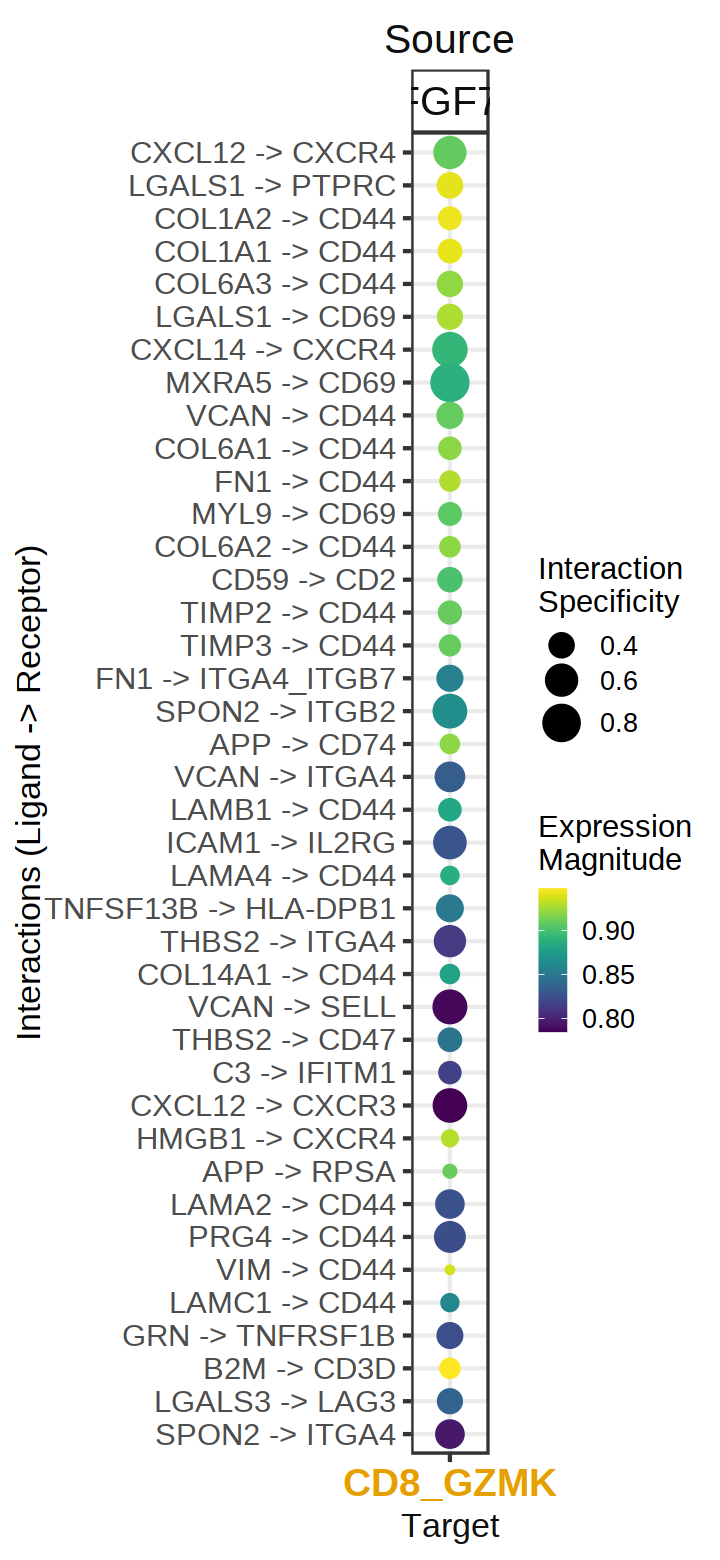

In [17]:
options(repr.plot.width=6, repr.plot.height=13)
liana_test_plot %>%
  liana_dotplot(source_groups = c('CAF_FGF7_HGF'),
                target_groups = c("CD8_GZMK"),ntop=40)

In [22]:
pdf('./results/figures/published/Figure4/liana_doubleCAF_cd8GZMK.pdf',width = 6,height = 14)
liana_test_plot %>%
  liana_dotplot(source_groups = c('CAF_FGF7_HGF'),
                target_groups = c("CD8_GZMK"),ntop=50)
dev.off()

png 
  2

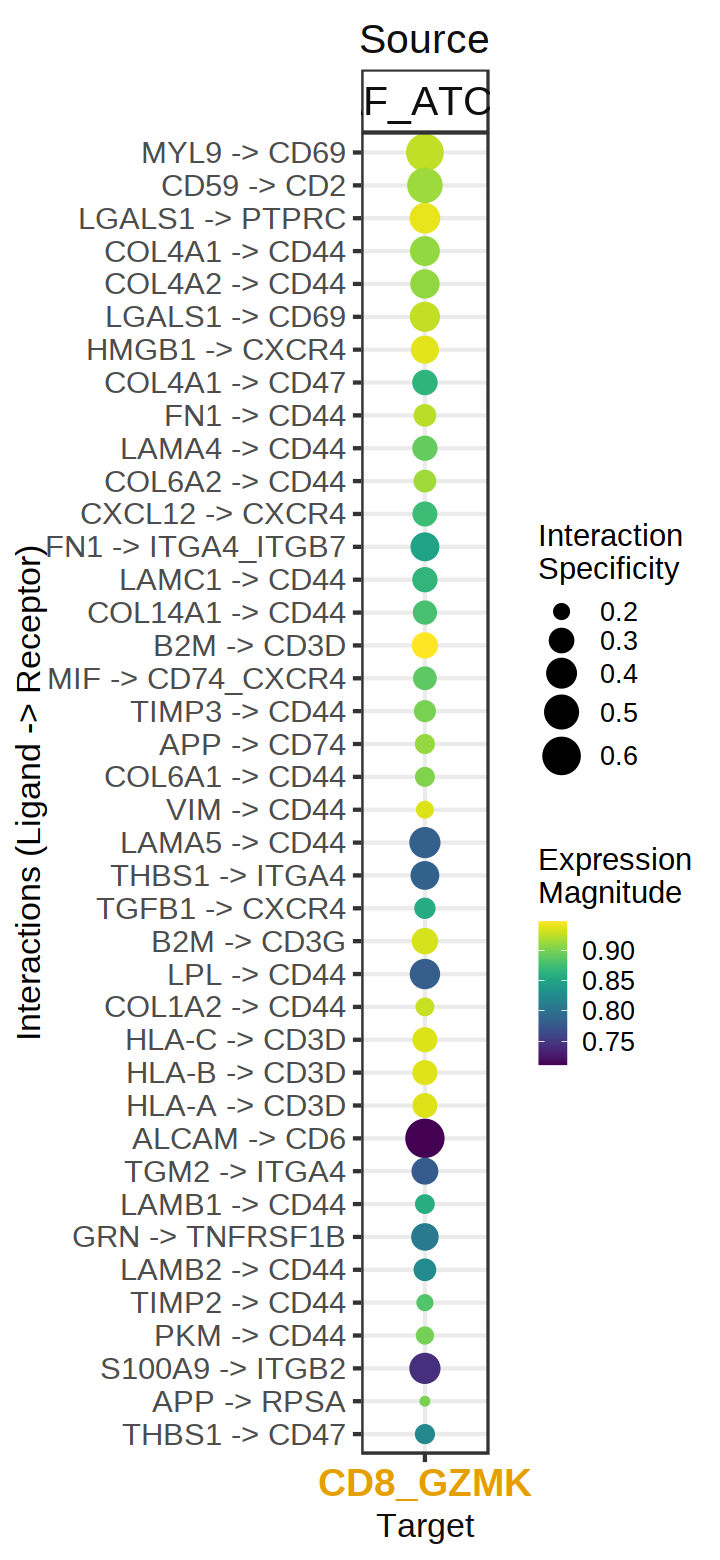

In [20]:
options(repr.plot.width=6, repr.plot.height=13)
liana_test_plot %>%
  liana_dotplot(source_groups = c('CAF_ATCA2'),
                target_groups = c("CD8_GZMK"),ntop=40)

In [23]:
pdf('./results/figures/published/Figure4/liana_nonCAF_cd8GZMK.pdf',width = 6,height = 14)
liana_test_plot %>%
  liana_dotplot(source_groups = c('CAF_ATCA2'),
                target_groups = c("CD8_GZMK"),ntop=40)
dev.off()

png 
  2